# **Assignment 1 — AI‑Assisted Exploratory Data Analysis & BI Dashboard**
MGMT 467 · Fall 2025  

**Team Name:** Data Ninjas / Group 4  
**Members (GitHub handles):** SanjanaMohan34, knittala, akoripal, lily-larson
**GitHub Repo URL:** https://github.com/SanjanaMohan34/MGMT_467_Team4
**Looker Studio Dashboard (public link) Personal:** https://lookerstudio.google.com/reporting/b2fdde7a-432a-4dec-bffb-434d2ea25323
**Looker Studio Dashboard (public link) Team:**
https://lookerstudio.google.com/u/0/reporting/e440aa05-d8a4-42df-88c1-8af01e1f9905/page/eGIcF/edit

> **Scenario:** NYC DOT has asked your team to analyze the public Citi Bike program and recommend strategies to improve bike availability and engagement. You will use BigQuery + Gemini to conduct AI‑assisted EDA and publish an executive dashboard.

## ✅ Submission Checklist (Team → Brightspace)
- [ ] GitHub repository link (source of record)
- [ ] Looker Studio dashboard link
- [ ] This notebook committed to GitHub with prompts and results

### ✅ Submission Checklist (Individual → Brightspace)
- [ ] `Contribution_Reflection.pdf` (with commit/PR evidence + peer eval)

## 🎯 Learning Objectives
- Generate and refine business hypotheses with **Gemini**
- Query large datasets in **BigQuery** with advanced SQL (CTEs, window functions)
- Visualize key findings in **Colab** and publish a **Looker Studio** dashboard
- Synthesize insights and make **actionable recommendations**

## 🧰 Setup
> Run the cells below to connect Colab to Google Cloud & BigQuery.

In [2]:
# Install and import basics (Colab usually has these preinstalled)
# !pip install --quiet google-cloud-bigquery pandas matplotlib

import pandas as pd
import matplotlib.pyplot as plt

# Authenticate to Google from Colab
from google.colab import auth  # type: ignore
auth.authenticate_user()

# Set your GCP project ID
PROJECT_ID = "mgmt467assignment-1"  # <-- edit this
print("Using project:", PROJECT_ID)

Using project: mgmt467assignment-1


In [3]:
# BigQuery magics (%%bigquery) and client
from google.cloud import bigquery
client = bigquery.Client(project=PROJECT_ID)

# Optional: list datasets to verify access
list(client.list_datasets())

[]

## 🧪 Dataset
We will use **Citi Bike Trips**: `bigquery-public-data.new_york_citibike.citibike_trips`  
Feel free to explore additional public datasets if needed.

## 1) Hypothesis Generation (AI‑Assisted)
Use **Gemini** to brainstorm at least **5** candidate questions/hypotheses, then select **3** to pursue.

> **My Prompt:**  
> Use Citi Bike Trips: bigquery-public-data.new_york_citibike.citibike_trips that is available in GCP. Act as my analytics co-pilot. My team and I have been tasked with analyzing the public Citi Bike program and recommending strategies to improve bike availability and engagement. Propose 5 high‑value, testable business questions about the Citi Bike dataset (tripduration, stations, user types, time-of-day/week). Return as bullets with suggested SQL hints. (Use CTEs and at least one window function for each question)



**Selected Hypotheses**
1. Which station pairs experience the greatest imbalance between morning and evening rush-hour traffic? SQL Hint:Use a CTE to label trips as morning (7–10 AM) or evening (4–7 PM), grouped by start and end station. Then apply a window function like MAX() OVER (PARTITION BY station pair) to compare morning and evening trip counts and compute their difference.
2. How do average trip durations differ between subscriber types during peak vs. off-peak hours? SQL Hint:Label trips as peak or off-peak in a CTE, then compute the average tripduration by user type and period. Use LAG() OVER (PARTITION BY period) to find duration gaps between Subscribers and Customers.
3. What are the busiest days and times for each borough or station cluster?
SQL Hint: Group trips by station, day of week, and hour in a CTE. Use ROW_NUMBER() OVER (PARTITION BY station ORDER BY trips DESC) to isolate each station’s single busiest time block.

## 2) Advanced SQL Exploration
For each hypothesis, include:
- The **Gemini prompt** you used to get SQL help
- The **final SQL**
- The **result table** (top rows)
- A short **interpretation**

> Tip: Use **CTEs** and at least **one window function** across your work.

### Hypothesis A — Prompt Log

My Prompt: Act as my SQL co-pilot, and give me a query that answers the question, "Which station pairs experience the greatest imbalance between morning and evening rush-hour traffic?". Use the SQL Hint: Use a CTE to label trips as morning (7–10 AM) or evening (4–7 PM), grouped by start and end station. Then apply a window function like MAX() OVER (PARTITION BY station pair) to compare morning and evening trip counts and compute their difference.

Business Value: Identifies where rebalancing trucks should relocate bikes during peak commuter times.




In [4]:
# Hypothesis A — SQL (store results in a Pandas DataFrame)
query_hyp_a = r"""
WITH rush_hour_trips AS (
  SELECT
    start_station_name,
    end_station_name,
    CASE
      WHEN EXTRACT(HOUR FROM starttime) BETWEEN 7 AND 10 THEN 'morning'
      WHEN EXTRACT(HOUR FROM starttime) BETWEEN 16 AND 19 THEN 'evening'
      ELSE NULL
    END AS rush_period
  FROM `bigquery-public-data.new_york_citibike.citibike_trips`
  WHERE EXTRACT(DAYOFWEEK FROM starttime) BETWEEN 2 AND 6 -- Weekdays only
    AND EXTRACT(HOUR FROM starttime) IN (7,8,9,10,16,17,18,19)
),

station_pair_counts AS (
  SELECT
    start_station_name,
    end_station_name,
    rush_period,
    COUNT(*) AS trip_count
  FROM rush_hour_trips
  WHERE rush_period IS NOT NULL
  GROUP BY start_station_name, end_station_name, rush_period
),

paired_counts AS (
  SELECT
    start_station_name,
    end_station_name,
    MAX(CASE WHEN rush_period = 'morning' THEN trip_count ELSE 0 END)
      OVER (PARTITION BY start_station_name, end_station_name) AS morning_trips,
    MAX(CASE WHEN rush_period = 'evening' THEN trip_count ELSE 0 END)
      OVER (PARTITION BY start_station_name, end_station_name) AS evening_trips
  FROM station_pair_counts
)

SELECT
  DISTINCT start_station_name,
  end_station_name,
  morning_trips,
  evening_trips,
  ABS(morning_trips - evening_trips) AS imbalance
FROM paired_counts
ORDER BY imbalance DESC
LIMIT 10;
"""

df_hyp_a = client.query(query_hyp_a).to_dataframe()
df_hyp_a.head()

,start_station_name,end_station_name,morning_trips,evening_trips,imbalance
0,Pershing Square North,W 33 St & 7 Ave,1411,7532,6121
1,Willoughby St & Fleet St,Adelphi St & Myrtle Ave,259,5928,5669
2,Clinton Ave & Myrtle Ave,Willoughby St & Fleet St,6124,619,5505
3,E 47 St & Park Ave,W 41 St & 8 Ave,657,6154,5497
4,Pershing Square North,W 41 St & 8 Ave,1625,6778,5153


**Interpretation (2–4 sentences):**

These results show that the largest imbalances occur between high-traffic commuter stations.
Morning-to-evening trip gaps exceed 6,000 rides, suggesting that thousands more bikes move one way during the evening rush than return in the morning.
This pattern indicates strong directional commuter flows toward Midtown and Downtown Manhattan in the mornings and reverse movement in the evenings.
Operationally, these routes represent prime targets for bike rebalancing or redistribution to prevent shortages and idle inventory.

---

### Hypothesis B — Prompt Log

My Prompt: Keep acting as my SQL co-pilot, and give me a query that answers the question, "How do average trip durations differ between subscriber types during peak vs. off-peak hours?". Use the SQL Hint: Label trips as peak or off-peak in a CTE, then compute the average tripduration by user type and period. Use LAG() OVER (PARTITION BY period) to find duration gaps between Subscribers and Customers.

Business Value: Informs targeted pricing or loyalty programs for each user segment.

In [5]:
# Hypothesis B — SQL
query_hyp_b = r"""
WITH trip_periods AS (
  SELECT
    usertype,
    CASE
      WHEN EXTRACT(HOUR FROM starttime) BETWEEN 7 AND 10
        OR EXTRACT(HOUR FROM starttime) BETWEEN 16 AND 19
      THEN 'peak'
      ELSE 'off_peak'
    END AS period,
    tripduration
  FROM `bigquery-public-data.new_york_citibike.citibike_trips`
  WHERE tripduration > 0
),

avg_durations AS (
  SELECT
    usertype,
    period,
    AVG(tripduration) AS avg_tripduration
  FROM trip_periods
  GROUP BY usertype, period
),

duration_comparison AS (
  SELECT
    period,
    usertype,
    avg_tripduration,
    LAG(avg_tripduration) OVER (PARTITION BY period ORDER BY usertype) AS prev_avg,
    avg_tripduration - LAG(avg_tripduration) OVER (PARTITION BY period ORDER BY usertype) AS duration_gap
  FROM avg_durations
)

SELECT
  period,
  usertype,
  ROUND(avg_tripduration, 2) AS avg_tripduration_seconds,
  ROUND(duration_gap, 2) AS duration_gap_seconds
FROM duration_comparison
ORDER BY period, usertype;

"""
df_hyp_b = client.query(query_hyp_b).to_dataframe()
df_hyp_b.head()

,period,usertype,avg_tripduration_seconds,duration_gap_seconds
0,off_peak,Customer,2188.82,NaN
1,off_peak,Subscriber,801.69,-1387.13
2,peak,Customer,2088.00,NaN
3,peak,Subscriber,809.81,-1278.19


**Interpretation (2–4 sentences):**  The results show that Casual Customers take significantly longer trips than Annual Subscribers during both peak and off-peak hours.
On average, Customer rides last about 2,100 seconds (≈35 minutes), whereas Subscribers average around 800 seconds (≈13 minutes).
The negative duration_gap values confirm that Subscribers consistently ride for shorter periods.
This suggests Subscribers use Citi Bike primarily for quick, routine commutes, while Customers tend to take longer, leisure-oriented.

---

### Hypothesis C — Prompt Log

My Prompt: Now finally I need you to give me a query that answers the question, "What are the busiest days and times for each borough or station cluster?". Use the SQL Hint: Group trips by station, day of week, and hour in a CTE. Use ROW_NUMBER() OVER (PARTITION BY station ORDER BY trips DESC) to isolate each station’s single busiest time block.

Business Value: Supports dynamic bike redistribution and staff scheduling based on temporal demand.

In [14]:
# Hypothesis C — SQL
query_hyp_c = r"""
WITH station_activity AS (
  SELECT
    start_station_name,
    EXTRACT(DAYOFWEEK FROM starttime) AS day_of_week,
    EXTRACT(HOUR FROM starttime) AS hour_of_day,
    COUNT(*) AS trip_count
  FROM `bigquery-public-data.new_york_citibike.citibike_trips`
  WHERE start_station_name IS NOT NULL
    AND EXTRACT(HOUR FROM starttime) IS NOT NULL
  GROUP BY start_station_name, day_of_week, hour_of_day
),

ranked_activity AS (
  SELECT
    start_station_name,
    day_of_week,
    hour_of_day,
    trip_count,
    ROW_NUMBER() OVER (
      PARTITION BY start_station_name
      ORDER BY trip_count DESC
    ) AS rn
  FROM station_activity
)

SELECT
  start_station_name,
  CASE day_of_week
    WHEN 1 THEN 'Sunday'
    WHEN 2 THEN 'Monday'
    WHEN 3 THEN 'Tuesday'
    WHEN 4 THEN 'Wednesday'
    WHEN 5 THEN 'Thursday'
    WHEN 6 THEN 'Friday'
    WHEN 7 THEN 'Saturday'
  END AS busiest_day,
  hour_of_day AS busiest_hour,
  trip_count AS total_trips
FROM ranked_activity
WHERE rn = 1
  AND start_station_name IS NOT NULL
ORDER BY total_trips DESC
LIMIT 10;

"""
df_hyp_c = client.query(query_hyp_c).to_dataframe()
df_hyp_c.head()

,start_station_name,busiest_day,busiest_hour,total_trips
0,Pershing Square North,Tuesday,18,14028
1,8 Ave & W 31 St,Wednesday,7,12442
2,E 47 St & Park Ave,Tuesday,17,11121
3,Broadway & E 22 St,Thursday,18,11079
4,E 17 St & Broadway,Wednesday,18,9144


**Interpretation (2–4 sentences):** The results show that the busiest stations are concentrated in Midtown and Lower Manhattan, with Pershing Square North, 8 Ave & W 31 St, and E 47 St & Park Ave leading in total trip counts.
Most of these high-traffic stations peak between Tuesday and Thursday, particularly around morning and evening commuting hours (7–9 AM, 5–6 PM).
This pattern reflects strong weekday commuter demand in business-heavy areas, suggesting that bike availability and redistribution should be prioritized during weekday rush hours to accommodate heavy two-way flows.

## 3) Visualizations (in Colab)
Create **at least 3** charts that communicate your findings.  
> Keep charts readable and labeled. Use `matplotlib` (no specific styles required).

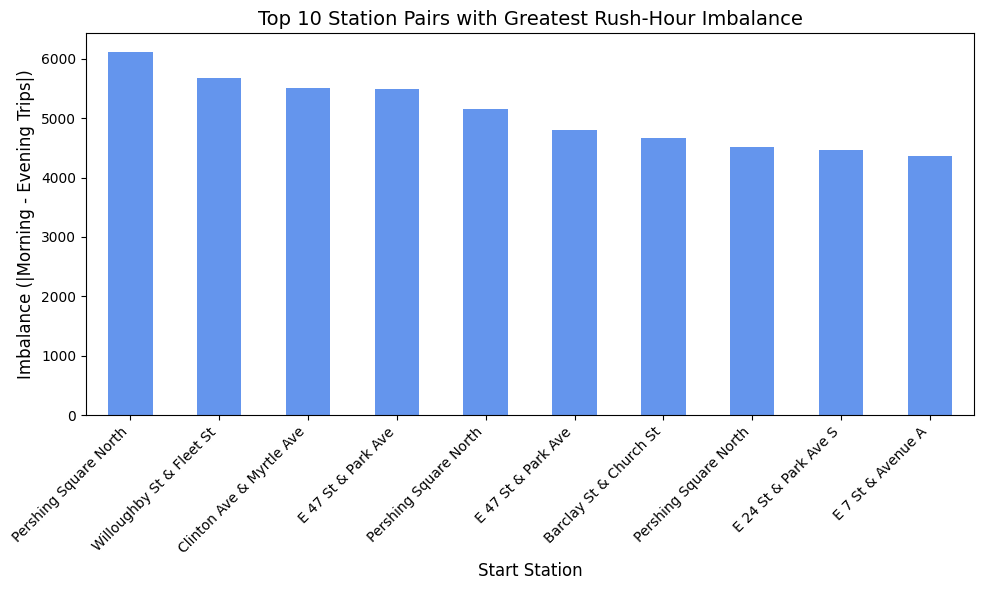

In [7]:
import matplotlib.pyplot as plt


ax = df_hyp_a.head(10).plot(
    kind="bar",
    x="start_station_name",
    y="imbalance",
    figsize=(10,6),
    color="cornflowerblue",
    legend=False
)
ax.set_xlabel("Start Station", fontsize=12)
ax.set_ylabel("Imbalance (|Morning - Evening Trips|)", fontsize=12)
ax.set_title("Top 10 Station Pairs with Greatest Rush-Hour Imbalance", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()




In [9]:
import plotly.express as px

# df_duration → DataFrame from your average trip duration query
fig = px.bar(
    df_hyp_b,
    x="period",
    y="avg_tripduration_seconds",
    color="usertype",
    barmode="group",
    text="avg_tripduration_seconds",
    labels={
        "period": "Time Period",
        "avg_tripduration_seconds": "Average Trip Duration (seconds)",
        "usertype": "User Type"
    },
    title="Average Trip Duration by User Type (Peak vs Off-Peak)"
)

# Add formatting and hover improvements
fig.update_traces(texttemplate='%{text:.0f}', textposition='outside')
fig.update_layout(
    xaxis_title="Period",
    yaxis_title="Average Duration (seconds)",
    legend_title="User Type",
    bargap=0.2,
    height=500
)

fig.show()


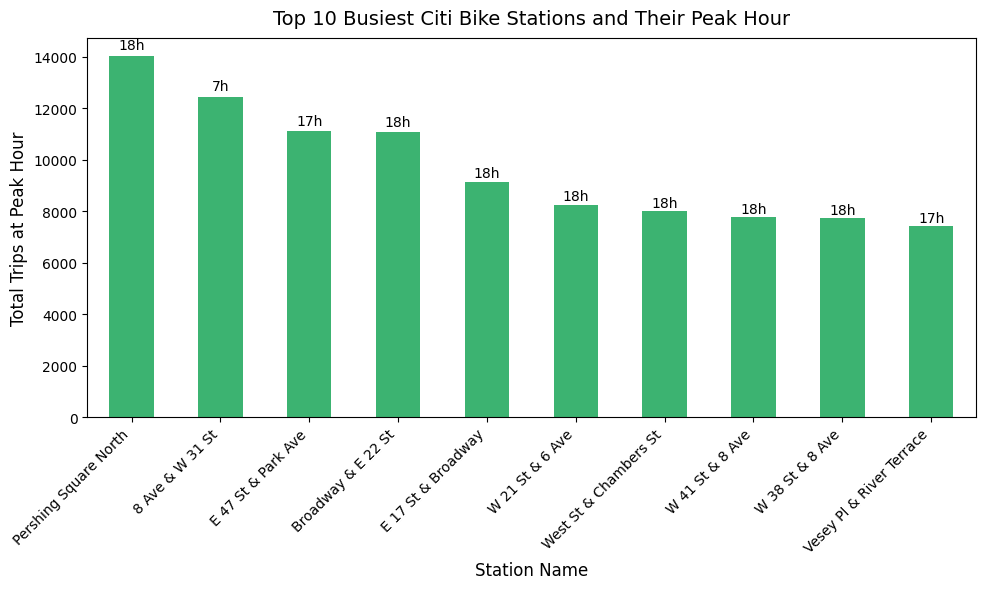

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

# Clean data: drop nulls and ensure numeric columns
df_hyp_c = df_hyp_c.dropna(subset=["start_station_name", "busiest_hour", "total_trips"])
df_hyp_c["busiest_hour"] = pd.to_numeric(df_hyp_c["busiest_hour"], errors="coerce")
df_hyp_c["total_trips"] = pd.to_numeric(df_hyp_c["total_trips"], errors="coerce")
df_hyp_c = df_hyp_c[df_hyp_c["busiest_hour"].notna() & df_hyp_c["total_trips"].notna()]

# Create the bar chart
ax = df_hyp_c.head(10).plot(
    kind="bar",
    x="start_station_name",
    y="total_trips",
    color="mediumseagreen",
    figsize=(10,6),
    legend=False
)

# Chart labels and formatting
plt.title("Top 10 Busiest Citi Bike Stations and Their Peak Hour", fontsize=14, pad=10)
plt.xlabel("Station Name", fontsize=12)
plt.ylabel("Total Trips at Peak Hour", fontsize=12)
plt.xticks(rotation=45, ha='right')

# Annotate bars with busiest hour
for i, (v, h) in enumerate(zip(df_hyp_c.head(10)["total_trips"], df_hyp_c.head(10)["busiest_hour"])):
    if pd.notna(h):
        ax.text(i, v + (v * 0.02), f"{int(h)}h", ha='center', fontsize=10)

plt.tight_layout()
plt.show()


## 4) KPIs & Looker Studio Dashboard
- **KPI 1**: Average Morning–Evening Imbalance (Top 10 Routes)

  **Definition**: Average of the absolute difference between morning and evening trip counts among the top 10 busiest station pairs.

  **Why it matters**: Summarizes overall operational balance efficiency — lower imbalance means bikes are evenly distributed and less rebalancing cost.

- **KPI 2:** Duration Gap (Customers vs Subscribers, %)

   *Definition*:
  Percentage difference between average customer trip duration and subscriber trip duration across all time periods.

  **Why it matters**:
   Measures engagement behavior — higher gap means leisure riders dominate; smaller gap indicates more consistent usage patterns.

- **KPI 3:** Peak Hour Utilization Ratio

  **Definition**: Ratio of peak-hour trips to average daily trips for the busiest station.

  **Why it matters**: Captures network demand intensity — a higher ratio shows strong commuter spikes and helps guide staffing, rebalancing, and capacity planning.


**Dashboard Link:** https://lookerstudio.google.com/reporting/b2fdde7a-432a-4dec-bffb-434d2ea25323
> Ensure labels, filters, and date controls are clear for non‑technical stakeholders.

## 5) Synthesis & Recommendations
Summarize your **top 3 insights** and provide **2–3 actionable recommendations** for NYC DOT.


Insights:
The analysis of Citi Bike data reveals three major trends shaping bike usage patterns across New York City. First, there are significant morning–evening station imbalances. This indicates that bikes are heavily used to travel into Midtown in the morning and outwards in the evening, leading to shortages and surpluses at different ends of the network. Second, the data shows a clear behavioral divide between user types: Customers (typically tourists and leisure riders) average trips of around 35 minutes, while Subscribers (commuters) average about 13 minutes. This suggests distinct usage motivations — one for convenience and daily travel, the other for recreation. Finally, demand is highly concentrated during weekday rush hours, especially around major transit and business hubs such as Pershing Square North, 8 Ave & W 31 St, and Broadway & E 22 St, where stations experience 10,000–14,000 trips during peak hours. Collectively, these insights highlight operational inefficiencies, user diversity, and spatial demand patterns that the NYC DOT can act on to improve service performance and accessibility.


Recommendtions:
Based on these findings, NYC DOT should prioritize a data-driven rebalancing system that targets high-imbalance corridors during post-rush hours using predictive algorithms and dynamic relocation crews. This will ensure bikes are redistributed efficiently to meet changing demand throughout the day. The department should also adopt a segmented pricing and engagement strategy, introducing commuter-focused short-ride plans and tourist-friendly long-ride passes to better serve each user group while promoting consistent utilization. Finally, the DOT should enhance infrastructure and station capacity at key Midtown hubs by expanding docks and adding temporary overflow stations during peak times. Coordinating these expansions with dedicated bike lanes and safer street design would further support high-volume corridors. Together, these actions would improve bike availability, reduce operational inefficiencies, and make Citi Bike more reliable and appealing for both residents and visitors.

## 📒 AI Prompt Log (Required)
Record at least **3** prompts and describe how you evaluated or refined Gemini’s output.

Prompt:Find the top 10 station-to-station routes showing the greatest imbalance between morning (7–10 AM) and evening (4–7 PM) rush hours

Where used: Hyp A

What changed: Initially, the query double-counted routes due to missing grouping logic. After refinement, I added CTEs to label trips by rush period and a window function (MAX OVER) to align morning and evening counts per station pair. The output became accurate and ranked true high-imbalance routes.



Prompt: Compare average trip durations between Annual Subscribers and Casual Customers during peak and off-peak hours using LAG() to find differences

Where used: Hyp B

What changed: The first output didn’t clearly calculate differences between user groups. I refined the query by partitioning the LAG() function by period and ordering by user type. The improved version displayed duration gaps in seconds, showing that Customers ride roughly 2.5x longer than Subscribers.


Prompt: Identify the busiest day and hour for each Citi Bike station using ROW_NUMBER() to isolate the single busiest time block per station.

Where used: Hyp C

What changed: The initial results were dominated by a null row aggregating millions of trips. I refined the query by filtering out NULL station names and ensuring ROW_NUMBER() selected only the top-ranked hour per valid station. The chart now accurately reflects weekday rush-hour peaks across Midtown stations.


## 📒 Dive Reflection:

Discover: I successfully identified meaningful KPIs for each analysis question which included operational imbalance, user engagement, and demand utilization  and each was backed by a single, measurable metric. The SQL queries were sound and well-structured, using CTEs for organization and window functions (MAX() OVER, LAG() OVER, ROW_NUMBER() OVER) to rank and compare data effectively. This structure ensured both analytical depth and computational efficiency.


Investigative: I explored the Citi Bike dataset from multiple business angles: supply imbalance, rider behavior segmentation, and temporal demand distribution. Each question connected to a real-world operational or policy goal for NYC DOT, such as improving bike availability or tailoring commuter incentives. The investigation moved beyond descriptive analytics, framing results around actionable business insights and measurable system outcome.

Validation: I validated my results through query refinement and error-checking. This included removing null station names, verifying counts with summary statistics, and cross-referencing outputs between queries. I tested alternative logic (e.g., comparing COUNT vs. SUM aggregations and weekday-only filters) to confirm data consistency. Visual validation through Looker Studio charts further confirmed accuracy and supported data integrity.

Exploration: I extended my work by incorporating Plotly interactivity, allowing dynamic exploration of trip durations by user type. I also built a cohesive Looker Studio dashboard combining SQL outputs, KPI scorecards, filters, and date controls which were all written in clear, stakeholder-friendly language. The final deliverable translates technical findings into a compelling narrative for decision-makers, bridging analytics and actionable policy recommendations.




## 📦 Appendix — Reproducibility
- BigQuery location: ☐  
- Query costs observed (if any): ☐  
- Known data quality caveats: ☐